In [1]:
# CPSC415/515 Big Data Programming
# Project 2: Visualization and MC simulation of stock prices

In [242]:
# DO NOT CHANGE THIS CELL
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import scipy as sp
from datetime import datetime
plt.rc("figure", figsize=(10, 6))
rm = np.random.default_rng(10) # 10 randome seed

# project input parameters
# you may assume column names are fixed, but do not hard code the stock tickers
initial_fund = 1000
tbillrate = 5.34
historical_stock_prices_file_name = "HistoricalStockData_year2Date.csv"

# parameters for simulation
num_simulations = 100
num_days = 20
confidence = 0.95

In [290]:
def load_data():
    
    file_path = "HistoricalStockData_year2Date.csv"
    df = pd.read_csv(file_path)
    
    tickers = df.iloc[2, 1:].dropna().tolist()

    all_dfs = []

    for i, ticker in enumerate(tickers):
         
        start_col = i * 6
        end_col = start_col + 6
        subset = df.iloc[:, start_col:end_col].rename(columns={
            df.columns[start_col]: 'Date',
            df.columns[start_col + 1]: 'Open',
            df.columns[start_col + 2]: 'Close',
            df.columns[start_col + 3]: 'High',
            df.columns[start_col + 4]: 'Low',
            df.columns[start_col + 5]: 'Volume'
        })
        subset['Ticker'] = ticker
        all_dfs.append(subset)

    data_combined = pd.concat(all_dfs, ignore_index=True)

    data_combined = data_combined[data_combined['Date'] != 'Date']
    
    for column in ['Open', 'Close']:
        data_combined[column] = pd.to_numeric(data_combined[column].str.replace(',', '').str.replace('$', ''), errors='coerce')
    
    data_combined['Date'] = pd.to_datetime(data_combined['Date'], errors='coerce')
    data_combined.dropna(subset=['Date'], inplace=True)
    data_combined['pDiff'] = ((data_combined['Close'] - data_combined['Open']) / data_combined['Open']) * 100
    data_combined['Date'] = data_combined['Date'].dt.strftime('%m/%d/%Y')

    return data_combined


data_combined = load_data()
print(data_combined)

            Date    Open   Close       High        Low       Volume Ticker  \
7     01/03/2023  130.28  125.07   $130.90    $124.17   112,117,471   AAPL   
8     01/04/2023  126.89  126.36   $128.66    $125.08    89,113,633   AAPL   
9     01/05/2023  127.13  125.02   $127.77    $124.76    80,962,708   AAPL   
10    01/06/2023  126.01  129.62   $130.29    $124.89    87,754,715   AAPL   
11    01/09/2023  130.47  130.15   $133.41    $129.89    70,790,813   AAPL   
...          ...     ...     ...        ...        ...          ...    ...   
1571  09/28/2023   97.94  102.76   $104.20     $97.76    72,542,056    AMD   
1572  09/29/2023  104.69  102.82   $104.94    $102.56    56,078,641    AMD   
1573  10/02/2023  102.21  103.27   $103.71    $101.70    45,118,574    AMD   
1574  10/03/2023  101.80  100.08   $103.29     $99.17    48,116,980    AMD   
1575  10/04/2023  100.65  104.07   $104.40    $100.34    51,023,246    AMD   

         pDiff  
7    -3.999079  
8    -0.417685  
9    -1.6597

C:\Users\samar\AppData\Local\Temp\ipykernel_15816\3022004223.py:32: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  data_combined['Date'] = pd.to_datetime(data_combined['Date'], errors='coerce')


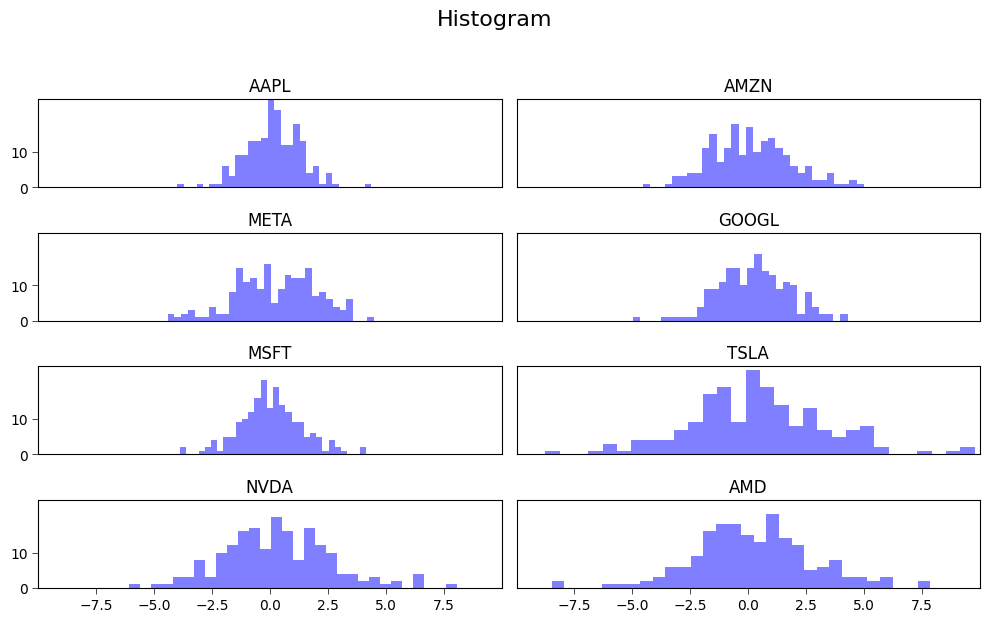

In [305]:
tickers = data_combined['Ticker'].unique()

fig, ax = plt.subplots(4, 2, figsize=(10, 6))
fig.suptitle("Histogram", fontsize=16, y=1.03)

for i, ticker in enumerate(tickers):
    row = i // 2
    col = i % 2

    data = data_combined[data_combined['Ticker'] == ticker]['pDiff']
    
    ax[row, col].hist(data, bins=30, color='blue', alpha=0.5)
    ax[row, col].set_title(ticker)
    
    ax[row, col].set_xlim(-10, 10)
    ax[row, col].set_ylim(0, 25)
    
    if col != 0:
        ax[row, col].set_yticks([])
    else:
        ax[row, col].set_yticks([0, 10])

    
    if row != 3:
        ax[row, col].set_xticks([])
    else:
        ax[row, col].set_xticks([-7.5, -5, -2.5, 0, 2.5, 5, 7.5])
    
    
    ax[row, col].tick_params(axis="y", direction="out", length=4, width=0.5)  
    ax[row, col].tick_params(axis="x", direction="out", length=4, width=0.5) 

plt.tight_layout()
plt.show()


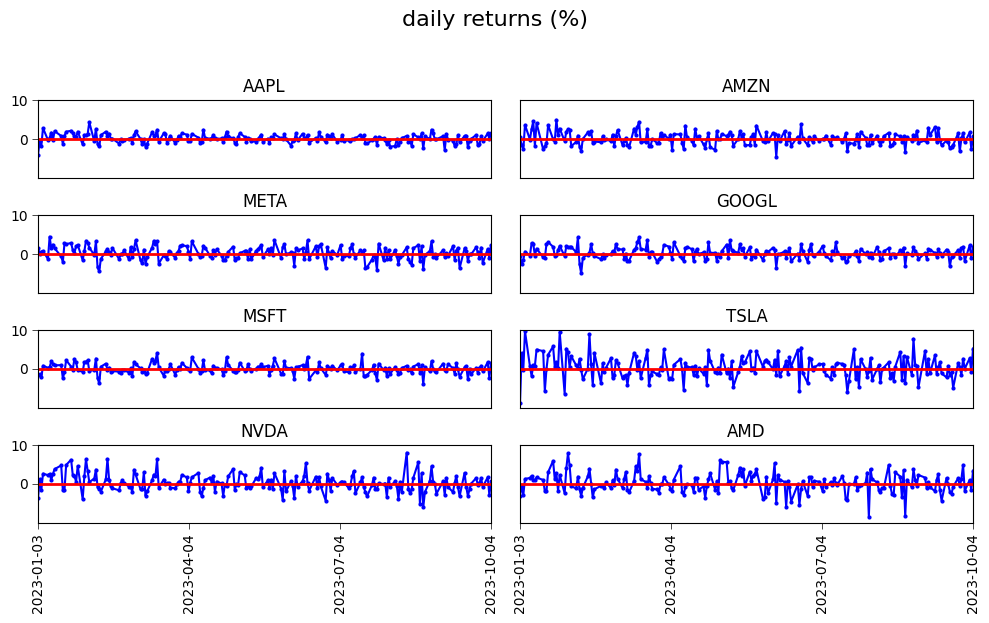

In [306]:
data_combined['Date'] = pd.to_datetime(data_combined['Date'])

tickers = data_combined['Ticker'].unique()

fig, ax = plt.subplots(4, 2, figsize=(10, 6))

date_min = data_combined['Date'].min()
date_max = data_combined['Date'].max()
date_interval = (date_max - date_min) / 3
dates_to_display = [date_min, date_min + date_interval, date_min + 2*date_interval, date_max]

fig.suptitle("daily returns (%)", fontsize=16, y=1.03)

for i, ticker in enumerate(tickers):
    row = i // 2
    col = i % 2
    
    ticker_data = data_combined[data_combined['Ticker'] == ticker]
    
    ax[row, col].plot(ticker_data['Date'], ticker_data['pDiff'], label=ticker, color='blue', marker='o', markersize=2.0, linestyle='-')  # Dots connected with a line
    ax[row, col].set_title(ticker)
    ax[row, col].axhline(0, color='red', linewidth=2.0)  
    
    ax[row, col].set_xlim(ticker_data['Date'].min(), ticker_data['Date'].max())
    ax[row, col].set_ylim(-10, 10)  
    ax[row, col].set_yticks([0, 10])  
    
    if col == 0:
        ax[row, col].set_yticks([0, 10])  
    else:
        ax[row, col].set_yticks([])
    
    ax[row, col].tick_params(axis="y", direction="out", length=4, width=0.5)  
    ax[row, col].tick_params(axis="x", direction="out", length=4, width=0.5)  
    
    
    if row != 3:
        ax[row, col].set_xticks([])
    else:
        ax[row, col].set_xticks(dates_to_display)
        ax[row, col].set_xticklabels([date.strftime('%Y-%m-%d') for date in dates_to_display],rotation=90)
        
plt.tight_layout()
plt.show()


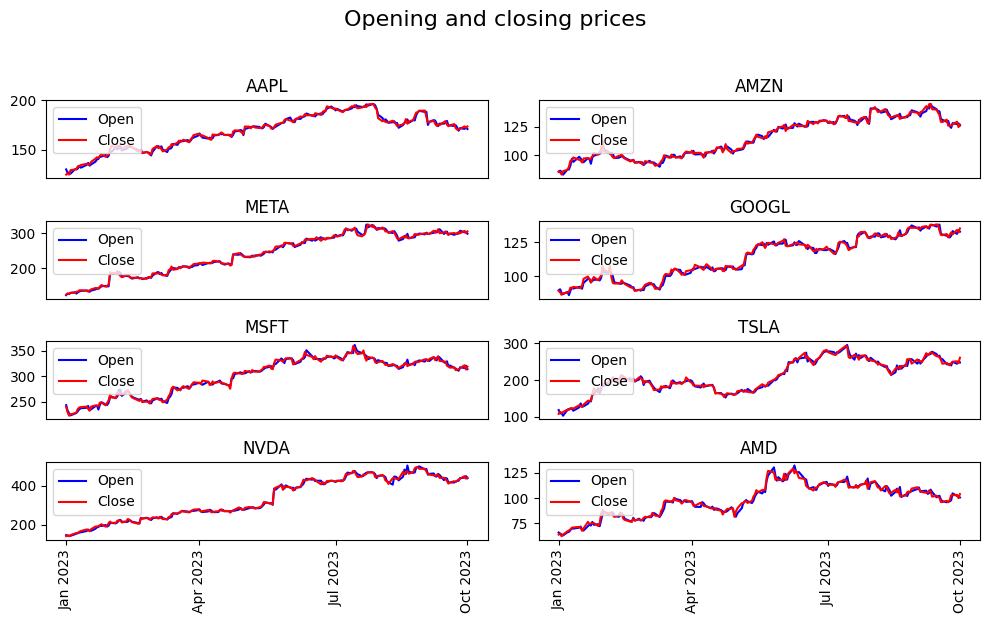

In [307]:
data_combined['Date'] = pd.to_datetime(data_combined['Date'])

columns_to_plot = ['Open', 'Close']
tickers = data_combined['Ticker'].unique()
color_map = {'Open': 'blue', 'Close': 'red'}

num_plots = len(tickers)
num_cols = 2  # two plots per row
num_rows = num_plots // num_cols + (num_plots % num_cols > 0)
fig, axes = plt.subplots(num_rows, num_cols, figsize=(10, 6))

if axes.ndim > 1:
    axes = axes.ravel()

for idx, ticker in enumerate(tickers):
    df_ticker = data_combined[data_combined['Ticker'] == ticker]
    
    for column in columns_to_plot:
        axes[idx].plot(df_ticker['Date'], df_ticker[column], label=column, color=color_map[column])
    
    axes[idx].set_title(f'{ticker}')
    axes[idx].legend(loc="upper left")

    
    if idx >= num_plots - num_cols:  
        num_ticks = 4
        date_list = df_ticker['Date'].tolist()
        step = len(date_list) // (num_ticks - 1)
        selected_dates = [date_list[i] for i in range(0, len(date_list), step)][:num_ticks]
        
        axes[idx].set_xticks(selected_dates)
        axes[idx].set_xticklabels([date.strftime('%b %Y') for date in selected_dates], rotation=90)
    else:
        axes[idx].set_xticks([])
        axes[idx].set_xticklabels([])

fig.suptitle('Opening and closing prices', fontsize=16, y=1.03)

plt.tight_layout()
plt.show()


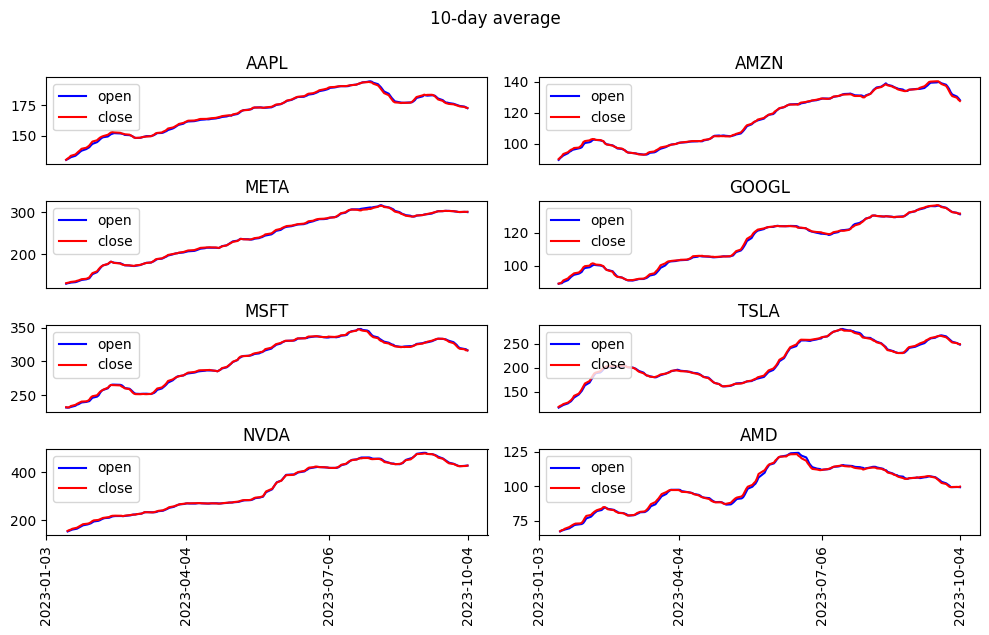

In [308]:
data_combined['Date'] = pd.to_datetime(data_combined['Date'])

data_combined['10-day SMA Open'] = data_combined.groupby('Ticker')['Open'].transform(lambda x: x.rolling(window=10).mean())
data_combined['10-day SMA Close'] = data_combined.groupby('Ticker')['Close'].transform(lambda x: x.rolling(window=10).mean())

tickers = data_combined['Ticker'].unique()

num_plots = len(tickers)
num_cols = 2  
num_rows = num_plots // num_cols + (num_plots % num_cols > 0)
fig, axes = plt.subplots(num_rows, num_cols, figsize=(10, 6))

if axes.ndim > 1:
    axes = axes.ravel()

for idx, ticker in enumerate(tickers):
    df_ticker = data_combined[data_combined['Ticker'] == ticker]
    
    axes[idx].plot(df_ticker['Date'], df_ticker['10-day SMA Open'], label='open', color='blue')
    axes[idx].plot(df_ticker['Date'], df_ticker['10-day SMA Close'], label='close', color='red')
    
    axes[idx].set_title(ticker)
    axes[idx].legend(loc='upper left')
   
    
    if idx >= num_plots - num_cols:  
        num_ticks = 4
        date_list = df_ticker['Date'].tolist()
        step = len(date_list) // (num_ticks - 1)
        selected_dates = [date_list[i] for i in range(0, len(date_list), step)][:num_ticks]
        
        axes[idx].set_xticks(selected_dates)
        for label in axes[idx].get_xticklabels():
            label.set_rotation(90)
    else:
        axes[idx].set_xticks([])

plt.tight_layout()
plt.suptitle("10-day average", y=1.05)
plt.show()


In [309]:
def simulation(data, rm, num_simulations, num_days):
    all_simulations = []  
    
    for ticker in data['Ticker'].unique():
        
        ticker_pDiff = data[data['Ticker'] == ticker]['pDiff'].values
        
        
        last_close = data[data['Ticker'] == ticker]['Close'].iloc[-1]
        
        
        simulations = np.zeros((num_simulations, num_days))
        simulations[:, 0] = last_close
        
        
        for sim in range(num_simulations):
            for day in range(1, num_days):
                random_diff = rm.choice(ticker_pDiff) / 100
                simulations[sim, day] = simulations[sim, day-1] * (1 + random_diff)
        
        
        for i in range(num_simulations):
            all_simulations.append(pd.DataFrame({f"{ticker}_sim_{i}": simulations[i]}))
            
    
    simulated_df = pd.concat(all_simulations, axis=1)
    
    return simulated_df

simulated_df = simulation(data_combined, rm, num_simulations, num_days)

print(simulated_df.head())

   AAPL_sim_0  AAPL_sim_1  AAPL_sim_2  AAPL_sim_3  AAPL_sim_4  AAPL_sim_5  \
0  173.660000  173.660000  173.660000  173.660000  173.660000  173.660000   
1  172.692567  176.741156  174.717590  172.842278  177.419364  178.635102   
2  172.146596  176.113373  174.551052  173.796007  177.980542  177.099526   
3  172.683870  177.441613  172.190952  172.762135  180.242744  179.383146   
4  176.049945  175.721646  174.506858  169.474886  179.213657  180.949414   

   AAPL_sim_6  AAPL_sim_7  AAPL_sim_8  AAPL_sim_9  ...  AMD_sim_90  \
0  173.660000  173.660000  173.660000  173.660000  ...  104.070000   
1  173.740777  170.777733  170.355667  172.458355  ...  104.060592   
2  173.821591  172.680833  169.999963  175.049623  ...  107.303451   
3  177.584454  176.251376  170.066713  177.427852  ...  107.990602   
4  176.270914  178.013889  170.170822  181.730617  ...  112.153617   

   AMD_sim_91  AMD_sim_92  AMD_sim_93  AMD_sim_94  AMD_sim_95  AMD_sim_96  \
0  104.070000  104.070000  104.070000  

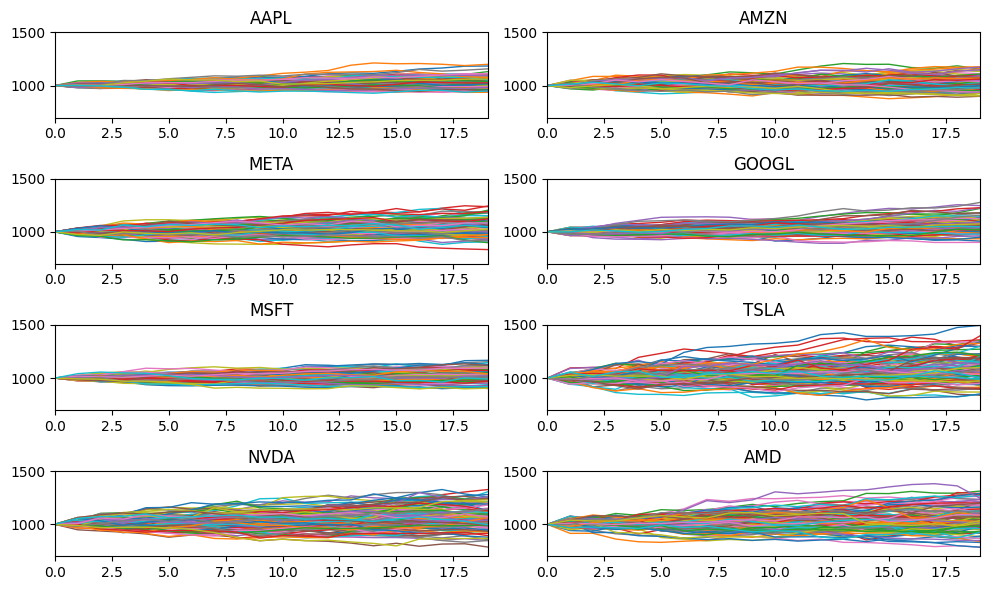

In [310]:
rm = np.random.default_rng(10)  
num_simulations = 100
num_days = 20
initial_fund = 1000

simulated_df = simulation(data_combined, rm, num_simulations, num_days)

tickers = data_combined['Ticker'].unique()

fig, axs = plt.subplots(4, 2, figsize=(10, 6))

for ax, ticker in zip(axs.ravel(), tickers):
    
    ticker_simulations = simulated_df.filter(like=f"{ticker}_sim_").values
    
    
    latest_close = data_combined[data_combined['Ticker'] == ticker]['Close'].iloc[-1]
    scale_factor = initial_fund / latest_close  
    
    for sim in ticker_simulations.T:  
        adjusted_sim = sim * scale_factor 
        ax.plot(adjusted_sim, lw=1) 
    
    ax.set_ylim(initial_fund * 0.7, initial_fund * 1.5)  
    ax.set_title(ticker)
    ax.set_xlim(0, num_days - 1)  

plt.tight_layout()
plt.show()


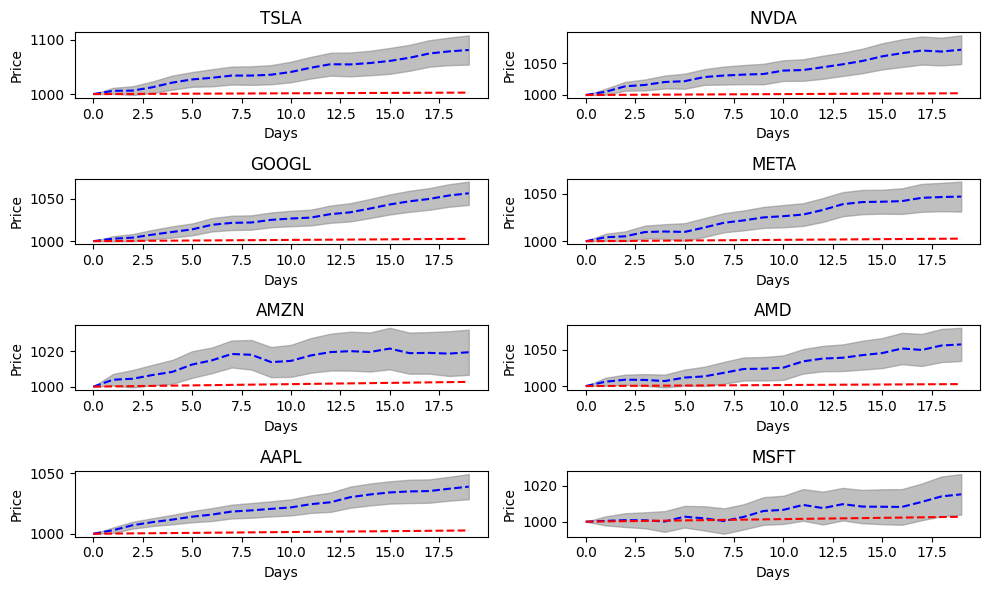

In [311]:

tbillrate = 5.34
daily_rate = (1 + tbillrate/100)**(1/365) - 1
tbill_growth = [initial_fund * ((1 + daily_rate) ** day) for day in range(0, num_days)]

tickers = list(set([col.split('_')[0] for col in simulated_df.columns]))

fig, axs = plt.subplots(4, 2, figsize=(10, 6))


for idx, ticker in enumerate(tickers):
    ax = axs[idx//2, idx%2]
    
    ticker_data = simulated_df[[col for col in simulated_df if ticker in col]]
    
    latest_close = data_combined[data_combined['Ticker'] == ticker]['Close'].iloc[-1]
    scale_factor = initial_fund / latest_close
    
    
    mean_values = ticker_data.mean(axis=1) * scale_factor
    std_dev_values = ticker_data.std(axis=1) * scale_factor
    
    
    upper_bound = mean_values + 1.96 * (std_dev_values / np.sqrt(num_simulations))
    lower_bound = mean_values - 1.96 * (std_dev_values / np.sqrt(num_simulations))
    
    ax.plot(mean_values, 'b--', label=f'{ticker} Expected Closing Price')
    ax.fill_between(mean_values.index, lower_bound, upper_bound, color='grey', alpha=0.5, label='95% CI')
    ax.plot(tbill_growth, 'r--', label='T-bill Returns')
    ax.set_title(ticker)
    ax.set_xlabel('Days')
    ax.set_ylabel('Price')

plt.tight_layout()
plt.show()


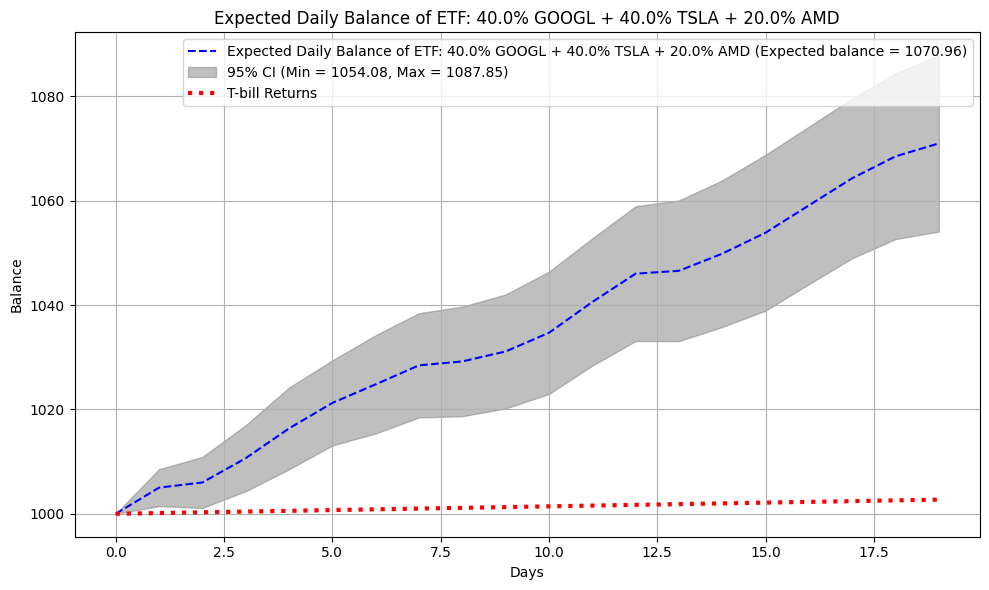

In [312]:
ETF_Stocks = ['GOOGL', 'TSLA', 'AMD']
proportion = [0.40, 0.40, 0.20]  

tbillrate = 5.34
daily_rate = (1 + tbillrate/100)**(1/365) - 1
tbill_growth = [initial_fund * ((1 + daily_rate) ** day) for day in range(0, num_days)]

etf_columns = [col for col in simulated_df.columns if any(ticker in col for ticker in ETF_Stocks)]
etf_simulated_data = simulated_df[etf_columns]

etf_returns = pd.DataFrame()
for i in range(num_simulations):
    combined_return = np.zeros(len(simulated_df))
    for idx, ticker in enumerate(ETF_Stocks):
        ticker_data = etf_simulated_data[f"{ticker}_sim_{i}"]
        combined_return += proportion[idx] * ticker_data
    etf_returns[f"ETF_sim_{i}"] = combined_return

latest_closes = [data_combined[data_combined['Ticker'] == ticker]['Close'].iloc[-1] for ticker in ETF_Stocks]
scale_factor = initial_fund / np.dot(proportion, latest_closes)
mean_values = etf_returns.mean(axis=1) * scale_factor
std_dev_values = etf_returns.std(axis=1) * scale_factor

upper_bound = mean_values + 1.96 * (std_dev_values / np.sqrt(num_simulations))
lower_bound = mean_values - 1.96 * (std_dev_values / np.sqrt(num_simulations))

plt.figure(figsize=(10, 6))
plt.plot(mean_values, 'b--', label=f'Expected Daily Balance of ETF: {" + ".join([f"{p*100}% {s}" for p, s in zip(proportion, ETF_Stocks)])} (Expected balance = {mean_values.iloc[-1]:.2f})')
plt.fill_between(mean_values.index, lower_bound, upper_bound, color='grey', alpha=0.5, label=f'95% CI (Min = {lower_bound.iloc[-1]:.2f}, Max = {upper_bound.iloc[-1]:.2f})')
plt.plot(tbill_growth, 'r:', linewidth=3, label='T-bill Returns')
plt.title(f"Expected Daily Balance of ETF: {' + '.join([f'{p*100}% {s}' for p, s in zip(proportion, ETF_Stocks)])}")
plt.xlabel('Days')
plt.ylabel('Balance')
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()
